# <font color='navy'> <center> REGRESSION - PREDICTION OF STORE SALES PROJECT

### <center> By Viha Sharma

# Table of contents:

1. Import Dependencies and Dataset  


2. Perform exploratory data analysis:  
    a. Dataset overview  
    b. Profile report generation  
    c. Univariate analysis  
    d. Bivariate analysis  
    
    
3. Perform data preprocessing:  
    a. Check for duplicate records  
    b. Missing value treatment  
    c. Feature encoding  
    d. Correlation heatmap for feature selection  
    e. Partitioning Target and independent features  
    f. Feature scaling  
    
    
4. Model Building  
    I. Linear Regression  
    II. XGBoost + Hyperparameter tuning using GridSearchCV  
    III. Decision Trees + Hyperparameter tuning using GridSearchCV  
    IV. Random Forests + Hyperparameter tuning using GridSearchCV  
    
    
5. Model Comparison    
    i. Evaluate test accuracy of each model  
    ii. Predict the test data for each model  
    iii. Evaluate the performance of test data using R-squared score, RMSE, MSE  


In [1]:
# Import dependencies

import pandas as pd 
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import time

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from sklearn.model_selection import RepeatedKFold, cross_val_score, train_test_split

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, StackingRegressor

# FINAL CLASS

In [13]:
class CommonFunctions:
    
    def read_file(self,file):
        '''
        Reads the file and stores it in a pnadas dataframe
        '''
        global df
        df = pd.read_csv(file)
        df.drop(['Item_Identifier','Outlet_Identifier'], axis=1, inplace=True) #drops irrelevant features for our regressor model
        return df
        
    def dataset_overview(self, df):
        '''
        provides a basic overview of the dataset
        '''
        print('\033[1;36mINITIAL DATASET OVERVIEW\033[0m')
        print('\033[1;3m1. Number of records:\033[0m',df.shape[0])
        print(' — — — — -')
        print('\033[1;3m2. Number of features:\033[0m', df.shape[1])
        print(' — — — — -')
        print('\033[1;3m3. Basic overview:\033[0m')
        print(df.info())
        print(' — — — — -')
        print('\033[1;3m4. Statistical summary:\033[0m',df.describe())
        print(' — — — — -')
        print('\033[1;3m5. Data types:\033[0m', df.dtypes)
        print(' — — — — -')
        print('\033[1;3m6. First 5 records:\033[0m',df.head())
        print(' — — — — -')
        print('\033[1;3m7. Last 5 records:\033[0m', df.tail())
        return df

    
    def visualisation(self,df):
        global numerical
        global obj
        numerical = [x for x in df.columns if df[x].dtype != 'object']
        obj = [x for x in df.columns if df[x].dtype == 'object']
        print('\033[1;36mNumerical Columns:\033[0m\n', numerical)
        print('\033[1;36mNon-numerical Columns:\033[0m\n', obj)

        for i in df:    
            if i in numerical:
                plt.subplots(figsize=(10,5), facecolor='linen')
                plt.title(i, fontweight='bold')
                sb.histplot(df[i], edgecolor='black', bins=100, kde=True)
                plt.xlim(df[i].min(), df[i].max())
                plt.subplots(figsize=(10,5), facecolor='linen')
                sb.boxplot(df[i], palette='PuBuGn')
                plt.title(f'Spread of {i}')
            elif i in obj:
                plt.subplots(figsize=(15,7), facecolor='linen')
                plt.title(i, fontweight='bold')
                plt.pie(df[i].value_counts(), labels = df[i].value_counts().index, autopct = '%.2f%%', shadow=True)
        return numerical, obj
    
    def impute_missing_vals(self, column):
        '''
        Replaces NaN sales values with the average values
        from their respective outlet types (Grocery store, Supermarket type1, etc)
        '''
        null_cols = []

        for i in df.columns:
            if df[i].isnull().sum() !=0:
                null_cols.append(i)
        print('Null column(s):\n', null_cols)
        df[column].fillna(df.groupby('Outlet_Type')[column].transform('mean'),inplace=True)
        print('\033[1;32mNull values treated!\033[0m')
        print(df.isnull().sum())
        return df
    
    def encoding(self, numerical, obj):
        '''
        performs label encoding on object datatypes to convert them to a numerical datatype
        '''
        encoder = LabelEncoder()
        for i in df:
            if i in obj:
                df[i+'_encoded'] = encoder.fit_transform(df[i])
                df.drop(i, axis=1, inplace=True)
        return df, numerical, obj

    def heatmap(self,df):
        '''
        Plots a correlation heatmap for all numerical features
        '''
        plt.figure(figsize=(15,8), facecolor='linen')
        sb.heatmap(df.corr(), annot=True)
        plt.title('HEATMAP FOR STORE DATASET', fontweight='bold', size=20)
        plt.show()
        
    def train_test(self, df):
        '''
        splits data into train and test after separating the dependent and independent features
        '''
        global X, y, x_train, x_test, y_train, y_test
        X = df.drop('Item_Outlet_Sales', axis=1)
        y = df['Item_Outlet_Sales']
        x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=2)
        return x_train, x_test, y_train, y_test
    
    def scaling(self, x_train, x_test):
        '''
        scales the independent features
        '''
        global X_train, X_test
        scaler =StandardScaler()
        X_train = pd.DataFrame(scaler.fit_transform(x_train.to_numpy()), columns= X.columns); X_train
        X_test = pd.DataFrame(scaler.transform(x_test.to_numpy()), columns= X.columns); X_test
        return X_train, X_test
    
    def main(self):
        self.read_file('DS3_C6_S1_Regression_StoreSales_Data_Project.csv')
        self.dataset_overview(df)
        self.visualisation(df)
        self.impute_missing_vals('Item_Outlet_Sales')
        print('\033[1;32mFeature encoding completed.\033[0m')
        self.encoding(numerical, obj) 
        self.train_test(df)
        print('\033[1;32mData splitting completed.\033[0m')
        self.scaling(x_train, x_test)
        print('\033[1;32mScaling of independent features completed.\033[0m')
        print()
        print('\033[1;32mIndependent features - Training set:\033[0m\n', X_train)
        print()
        print('\033[1;32mIndependent Features - Testing set:\033[0m\n',X_test)
        print()
        print('\033[1;32mDependent Feature:\033[0m\n', y)
        print('\033[1;32mUnivariate & Bivariate Analysis:\033[0m')

In [39]:
class MyMachineLearning:
    
    def BuildDecisionTree(self, model, X_train, X_test, y_train, y_test):
        '''
        Builds the optimal Decision Tree Regressor after hyperparameter tuning using GridSearchCV. 
        Model evaluation is also returned along with a comparison of actual and predicted values.
        '''
        global dt_params
        dt_params = {"max_depth": (3,5,7,10,20,30,50,60,100,150,200), 
                "min_samples_split": (3,5,10,20,25,30,50),
                "max_leaf_nodes": (3,5,10,15,20,25)}
        model = DecisionTreeRegressor()
        dt_grid = GridSearchCV(model, param_grid=dt_params, cv=5, verbose=1, n_jobs=-1)
        dt_grid.fit(X_train, y_train)
        model1 = dt_grid.best_estimator_
        model1.fit(X_train, y_train)
        global dt_pred, dt_mse, dt_rmse, dt_train_score, dt_test_score
        dt_pred = model1.predict(X_test)
        dt_train_score = model1.score(X_train, y_train)
        dt_test_score = r2_score(y_test, dt_pred)
        dt_mse = mean_squared_error(y_test, dt_pred)
        dt_rmse = mean_squared_error(y_test, dt_pred, squared=False)
        dt_df = pd.DataFrame(zip(y_test, dt_pred), columns = ['Actual Sales', 'Predicted Sales'])
        print()
        print('-----------------')
        print(f'\033[1;3mModel: {model}\033[0m')
        print()
        print('\033[1;36mTrain Score:\033[0m', dt_train_score)
        print('\033[1;36mTest Score:\033[0m', dt_test_score)
        print('\033[1;36mMean Squared Error:\033[0m', dt_mse)
        print('\033[1;36mRoot Mean Squared Error:\033[0m', dt_rmse)
        print()
        print(dt_df.head())

        
    def BuildLinearRegression(self, X_train, y_train, model):
        '''
        builds the Linear Regression model.
        Model evaluation is also returned along with a comparison of actual and predicted values.
        '''
        model.fit(X_train, y_train)
        global lr_pred, lr_mse, lr_rmse, lr_train_score, lr_test_score
        lr_pred = model.predict(X_test)
        lr_train_score = model.score(X_train, y_train)
        lr_test_score = r2_score(y_test, lr_pred)
        lr_mse = mean_squared_error(y_test, lr_pred)
        lr_rmse = mean_squared_error(y_test, lr_pred, squared=False)
        lr_df = pd.DataFrame(zip(y_test, lr_pred), columns = ['Actual Sales', 'Predicted Sales'])
        print()
        print('-----------------')
        print(f'\033[1;3mModel: {model}\033[0m')
        print()
        print('\033[1;36mTrain Score:\033[0m', lr_train_score)
        print('\033[1;36mTest Score:\033[0m', lr_test_score)
        print('\033[1;36mMean Squared Error:\033[0m', lr_mse)
        print('\033[1;36mRoot Mean Squared Error:\033[0m', lr_rmse)
        print()
        print(lr_df.head())
        
        
    def BuildRandomForest(self, model, X_train, X_test, y_train, y_test):
        '''
        Builds the optimal Random Forest Regressor after hyperparameter tuning using GridSearchCV. 
        Model evaluation is also returned along with a comparison of actual and predicted values.
        Further, feature importance is graphically potrayed, using the feature_importances_ method of 
        this algorithm.
        '''
        rf_params = {'max_depth': (2,4,6,8,10,25,50,100),
                'n_estimators': (2,3,5,7,9,20),
                 'min_samples_leaf': (5,10,20,50)}
        rf_grid = GridSearchCV(model, param_grid=dt_params, cv=5, verbose=1, n_jobs=-1)
        rf_grid.fit(X_train, y_train)
        model = rf_grid.best_estimator_
        model.fit(X_train, y_train)
        global rf_pred, rf_mse, rf_rmse, rf_train_score, rf_test_score
        rf_train_score = model.score(X_train, y_train)
        rf_pred = model.predict(X_test)
        rf_test_score = r2_score(y_test, dt_pred)
        rf_mse = mean_squared_error(y_test, rf_pred)
        rf_rmse = mean_squared_error(y_test, rf_pred, squared=False)
        rf_df = pd.DataFrame(zip(y_test, rf_pred), columns = ['Actual Sales', 'Predicted Sales'])
        print()
        print('-----------------')
        print(f'\033[1;3mModel: {model}\033[0m')
        print()
        print('\033[1;36mTrain Score:\033[0m',rf_train_score)
        print('\033[1;36mTest Score:\033[0m',rf_test_score)
        print('\033[1;36mMean Squared Error:\033[0m', rf_mse)
        print('\033[1;36mRoot Mean Squared Error:\033[0m', rf_rmse)
        print()
        print(rf_df.head())
        pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=['Feature_Importance']).sort_values(by='Feature_Importance',ascending=True).plot(kind='barh', figsize=(10,5))
        plt.title('FEATURE IMPORTANCE - RANKED MOST IMPORTANT TO LEAST IMPORTANT')
        plt.legend(loc='best')
        plt.figtext(0.42, 0.2, 'Outlet Type is the most significant feature, followed by Item MRP', ha="left", fontsize=10, bbox={"facecolor":"orange", "alpha":0.6, "pad":5})
        plt.show()
        
        
    def BuildSVR(self, X_train, y_train, model):
        '''
        Builds the SVR model.
        Model evaluation is also returned along with a comparison of actual and predicted values. 
        '''
        model.fit(X_train, y_train)
        global svr_pred, svr_mse, svr_rmse, svr_train_score, svr_test_score
        svr_pred = model.predict(X_test)
        svr_train_score = model.score(X_train, y_train)
        svr_test_score = r2_score(y_test, svr_pred)
        svr_mse = mean_squared_error(y_test, svr_pred)
        svr_rmse = mean_squared_error(y_test, svr_pred, squared=False)     
        svr_df = pd.DataFrame(zip(y_test, svr_pred), columns = ['Actual Sales', 'Predicted Sales'])
        print()
        print('-----------------')
        print(f'\033[1;3mModel: {model}\033[0m')
        print()
        print('\033[1;36mTrain Score:\033[0m', svr_train_score)
        print('\033[1;36mTest Score:\033[0m', svr_test_score)
        print('\033[1;36mMean Squared Error:\033[0m', svr_mse)
        print('\033[1;36mRoot Mean Squared Error:\033[0m', svr_rmse)
        print()
        print(svr_df.head())       
        
        
    def BuildXGBoostRegressor(self):
        '''
        Builds the optimal XGBoost Regressor after hyperparameter tuning using GridSearchCV. 
        Model evaluation is also returned along with a comparison of actual and predicted values.
        '''
        xg_params = {"max_depth": (2,5,10,20,30,50), 
            "subsample": (0.5,0.7,0.9,1),
            "n_estimators": (5,7,10,15,20,25),
            "learning_rate": (0.1,0.2,0.3,0.5,1)}
        xg_grid = GridSearchCV(XGBRegressor(), param_grid=xg_params,cv=5, scoring='r2', n_jobs=-1,verbose=1)
        xg_grid.fit(X_train,y_train)
        model = xg_grid.best_estimator_.fit(X_train, y_train)
        global xg_pred, xg_mse, xg_rmse, xg_train_score, xg_test_score
        xg_pred = model.predict(X_test)
        xg_train_score = model.score(X_train, y_train)
        xg_test_score = r2_score(y_test, xg_pred)
        xg_mse = mean_squared_error(y_test, xg_pred)
        xg_rmse = mean_squared_error(y_test, xg_pred, squared=False)   
        xg_df = pd.DataFrame(zip(y_test, xg_pred), columns = ['Actual Sales', 'Predicted Sales'])
        print()
        print('-----------------')
        print(f'\033[1;3mModel: {model}\033[0m')
        print('\033[1;36mTrain Score:\033[0m', xg_train_score)
        print('\033[1;36mTest Score:\033[0m', xg_test_score)
        print('\033[1;36mMean Squared Error:\033[0m', xg_mse)
        print('\033[1;36mRoot Mean Squared Error:\033[0m', xg_rmse)
        print()
        print(xg_df.head())  
        
        
    def BuildStackingRegressor(self):
        '''
        Builds the Stacking Regressor taking RandomForestRegressor, KNeighborsRegressor, DecisionTreeRegressor, and
        SVR as base learners. The Linear Regression model is the meta learner. 
        Model evaluation is also returned along with a comparison of actual and predicted values.
        '''
        level0 = []
        level0.append(('rf', RandomForestRegressor(max_depth=6, min_samples_leaf=50, n_estimators=20)))
        level0.append(('knn', KNeighborsRegressor(n_neighbors=10)))
        level0.append(('cart', DecisionTreeRegressor(max_depth= 5, max_leaf_nodes=20, min_samples_split= 3)))
        level0.append(('svm', SVR()))
        level1 = LinearRegression()
        model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
        model.fit(X_train, y_train)
        model.score(X_train, y_train)
        global stack_pred, stack_mse, stack_rmse, stack_train_score, stack_test_score
        stack_pred = model.predict(X_test)
        stack_test_score = r2_score(y_test, dt_pred)
        stack_train_score = model.score(X_train, y_train)
        stack_mse = mean_squared_error(y_test, stack_pred)
        stack_rmse = mean_squared_error(y_test, stack_pred, squared=False) 
        stack_df = pd.DataFrame(zip(y_test, stack_pred), columns = ['Actual Sales', 'Predicted Sales'])
        print()
        print('-----------------')
        print(f'\033[1;3mModel: {model}\033[0m')
        print('Training Score:',stack_train_score)
        print('Testing Score:',stack_test_score)
        print('\033[1;36mMean Squared Error:\033[0m', stack_mse)
        print('\033[1;36mRoot Mean Squared Error:\033[0m', stack_rmse)
        print()
        print(stack_df.head())
        
        
    def BuildAdaboostRegressor(self):
        '''
        Builds the optimal AdaBoost Regressor after hyperparameter tuning using GridSearchCV. 
        Model evaluation is also returned along with a comparison of actual and predicted values.
        '''
        ada_params = {'n_estimators': [2,3, 4,5,10,15,20,25,100],
                 'learning_rate':[0.2,0.3,0.4,0.5,0.7,1.0]}
        ada_grid = GridSearchCV(AdaBoostRegressor(random_state=42), param_grid=ada_params, scoring='r2', cv=5, verbose=1, n_jobs=-1)
        ada_grid.fit(X_train, y_train)
        model = ada_grid.best_estimator_
        ada_model = model.fit(X_train, y_train)
        global ada_pred, ada_mse, ada_rmse, ada_train_score, ada_test_score        
        ada_pred = ada_model.predict(X_test)
        ada_train_score = ada_model.score(X_train, y_train)
        ada_test_score = ada_model.score(X_test, y_test)
        ada_mse = mean_squared_error(y_test, ada_pred)
        ada_rmse = mean_squared_error(y_test, ada_pred, squared=False) 
        ada_df = pd.DataFrame(zip(y_test, xg_pred), columns = ['Actual Sales', 'Predicted Sales'])
        print()
        print('-----------------')
        print(f'\033[1;3mModel: {model}\033[0m')
        print('\033[1;36mTrain Score:\033[0m', ada_train_score)
        print('\033[1;36mTest Score:\033[0m', ada_test_score)
        print('\033[1;36mMean Squared Error:\033[0m', ada_mse)
        print('\033[1;36mRoot Mean Squared Error:\033[0m', ada_rmse)
        print()
        print(ada_df.head())
        print('-----------------')


        
    def ModelComparison(self):
        '''
        Creates a dataframe to display all evaluation metrics in a tablular format. This dataframe is saved
        to the directory in a csv file. Comparison graphs are plotted for all corresponding metrics.
        Further, the regressor with the lowest RMSE, lowest MSE and highest test scores are determined.
        '''
        train_scores = [lr_train_score,svr_train_score,dt_train_score, rf_train_score,xg_train_score, ada_train_score,stack_train_score]
        test_scores = [lr_test_score,svr_test_score,dt_test_score, rf_test_score,xg_test_score, ada_test_score,stack_test_score]
        mse_scores = [lr_mse,svr_mse,dt_mse, rf_mse,xg_mse, ada_mse,stack_mse]
        rmse_scores = [lr_rmse,svr_rmse,dt_rmse, rf_rmse,xg_rmse, ada_rmse,stack_rmse]
        
        scores_list = list(zip(train_scores, test_scores,np.round(mse_scores,3), np.round(rmse_scores,3)))

        scores_df = pd.DataFrame(scores_list, columns=['Train Score','Test Score', 'MSE', 'RMSE']); scores_df
        scores_df.index=['Linear Regression', 'SVR', 'Decision Tree Regressor', 'Random Forest Regressor', 'XGBoost Regressor', 'AdaBoost Regressor', 'Stacking Regressor']
        print(scores_df)
        scores_df.to_csv('model_comparison.csv')
        for i in scores_df:
                plt.subplots(figsize=(10,5), facecolor='linen')
                plt.barh(y = scores_df.index, width=scores_df[i])
                plt.title(i, fontweight='bold', size=15)
        print()
        print('\033[1;3mCONCLUSION\033[0m')
        print('Model with lowest RMSE: ', scores_df['RMSE'].idxmin())
        print('Model with lowest MSE: ', scores_df['MSE'].idxmin())
        print('Best Regressor:', scores_df['Test Score'].idxmax())
    
    
    def main(self):
        '''
        Automates the MyMachineLearning class in the appropriate sequential manner. 
        The amount of time taken to perform all these class methods is also noted.
        '''
        print('\033[1;3mMODEL REPORTS\033[0m') 
        start = time.time()
        self.BuildLinearRegression(X_train, y_train, LinearRegression())
        self.BuildSVR(X_train, y_train, SVR())
        self.BuildDecisionTree(DecisionTreeRegressor, X_train, X_test, y_train, y_test)
        self.BuildRandomForest(RandomForestRegressor(), X_train, X_test, y_train, y_test)
        self.BuildStackingRegressor()
        self.BuildXGBoostRegressor()
        self.BuildAdaboostRegressor()
        self.ModelComparison()
        end = time.time()
        time_elapsed = end-start
        print()
        print('Total Modelling Time Taken:', time_elapsed, 's')

In [30]:
worker1 = CommonFunctions()

INITIAL DATASET OVERVIEW
1. Number of records: 14204
 — — — — -
2. Number of features: 10
 — — — — -
3. Basic overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                14204 non-null  float64
 1   Item_Fat_Content           14204 non-null  object 
 2   Item_Visibility            14204 non-null  float64
 3   Item_Type                  14204 non-null  object 
 4   Item_MRP                   14204 non-null  float64
 5   Outlet_Establishment_Year  14204 non-null  int64  
 6   Outlet_Size                14204 non-null  object 
 7   Outlet_Location_Type       14204 non-null  object 
 8   Outlet_Type                14204 non-null  object 
 9   Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 1.1+ MB
None
 — — — — -
4. Statistical summar

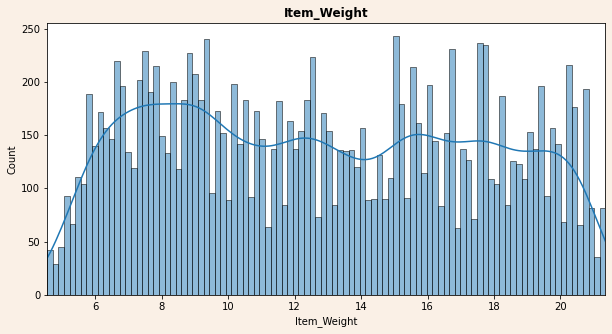

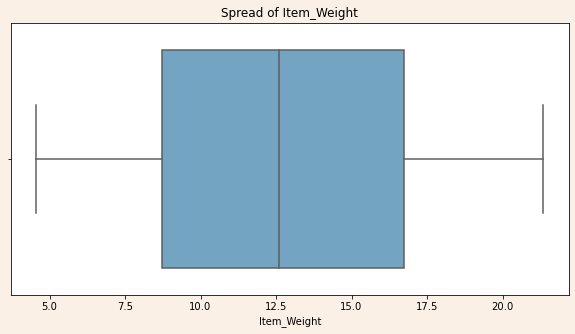

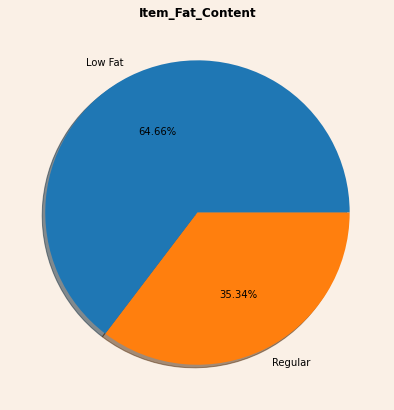

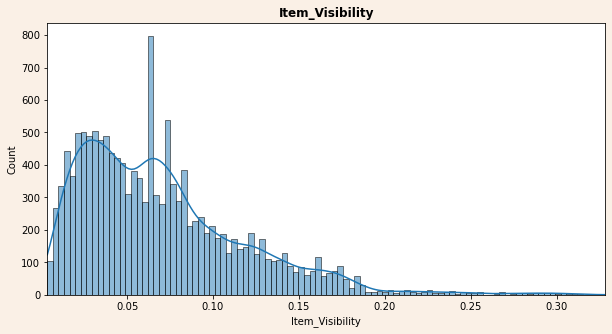

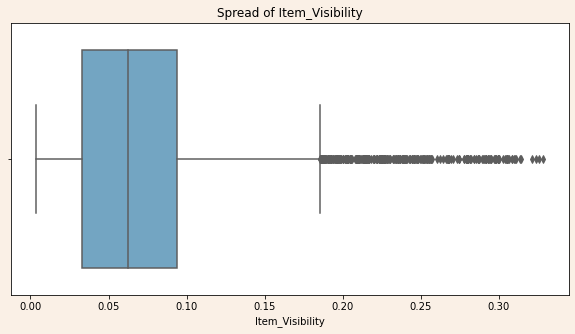

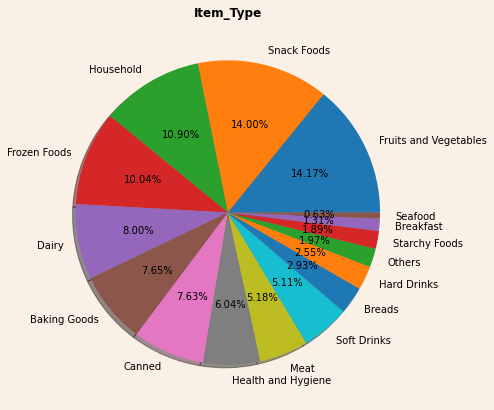

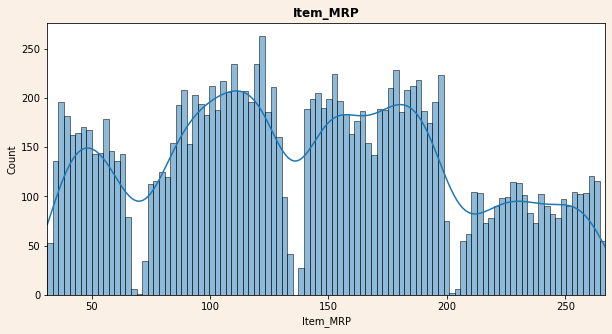

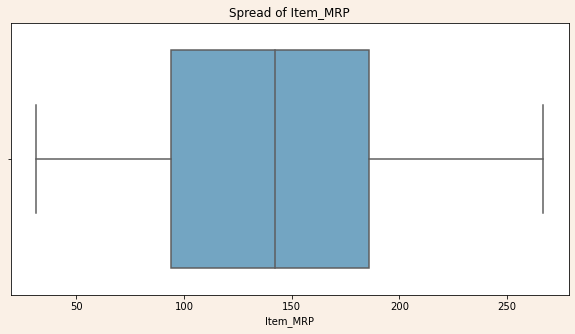

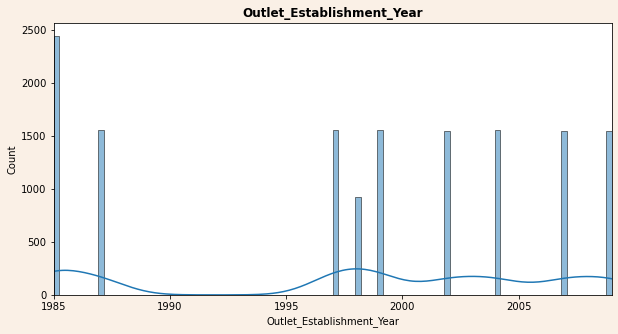

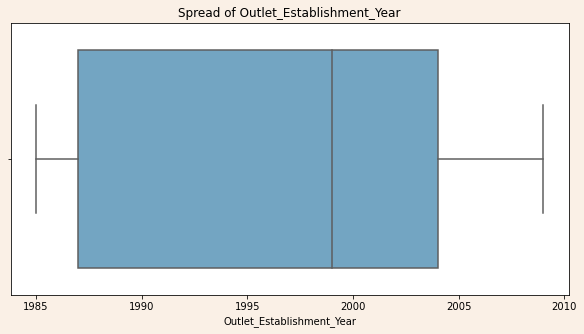

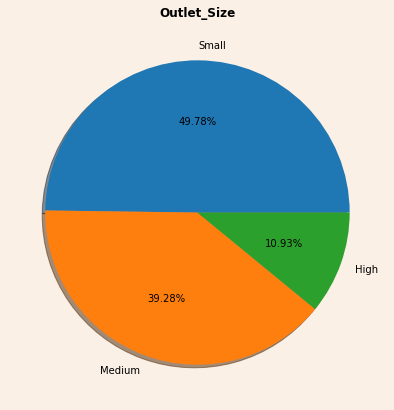

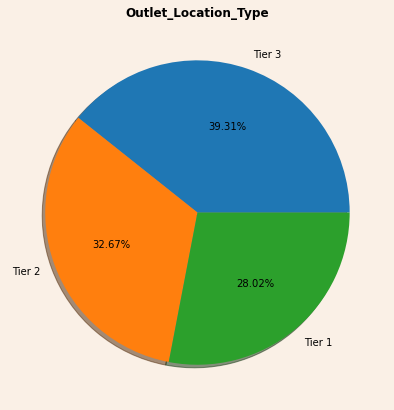

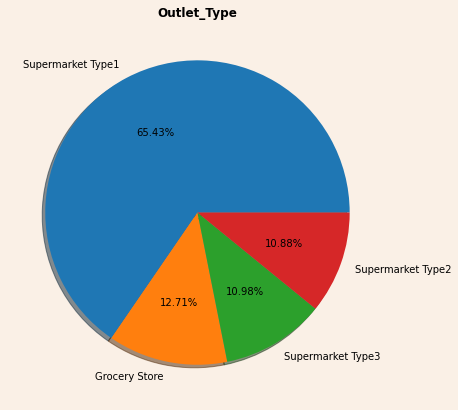

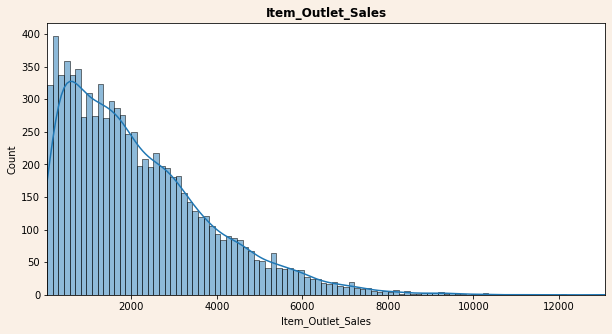

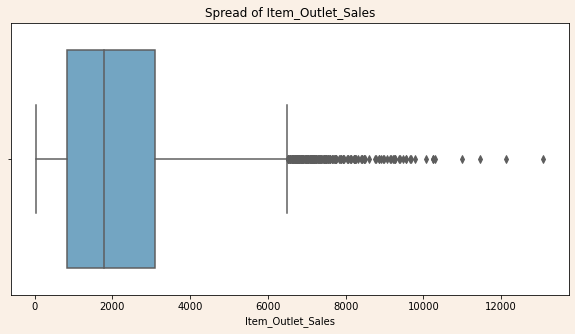

In [31]:
worker1.main()

--- 
<div class='alert-warning'> 

### Exploratory Data Analysis - Inferences
    
1. Item outlet sales and item_visibility are right skewed and contain many outliers
    
2. Most outlets are of supermarket Type 1 (~65%)
    
3. Outlet locations are approximately evenly distributed, with the Tier 3 outlets having the greatest share in our dataset (39%)
    
4. Nearly 50% of all items sold in our dataset came from a small outlet
    
5. The outlet identifier feature is evenly distributed
    
6. Item weights are approximately evenly distributed across the feature range, while there is slightly higher density between 6 to 10. 
    
7. 'Snack foods' and 'fruits and vegetable' item types have a higher share in our dataset.
    
8. Item MRP forms 4 high-density distributions, with an average MRP of 141. The data is also approximately normally distributed. 
   
9. Most items have a low fat content
    
</div>
    
---

<div class='alert alert-success'>  
    
### On average, Item sales are higher if:

a. They are sold in supermarket Type 3  
b. They are sold in Tier 2 outlet locations  
c. The outlet size is not small   
d. The item type is starchy  
e. The item has regular fat content
    </div>
---

<div class='alert alert-info'>

### Correlation Heatmap - Inferences: 
    
There is a moderate correlation between: 
    
1. Item MRP and Item Outlet Sales
2. Outlet Establishment Year and Outlet Size 
3. Outlet Sales and Outlet Type
4. Outlet Size and Outlet Location
5. Outlet Size and Outlet Type
6. Outlet Type and Outlet Location

    </div>


---

In [40]:
worker2 = MyMachineLearning()

MODEL REPORTS

-----------------
Model: LinearRegression()

Train Score: 0.4214694062137251
Test Score: 0.42237888189301664
Mean Squared Error: 1146405.1758523935
Root Mean Squared Error: 1070.7031221829857

   Actual Sales  Predicted Sales
0   1995.498739      1812.399640
1    339.828500       676.490997
2   3142.576000      2446.997374
3   2143.876000      2975.275657
4   2316.181148      2680.497269

-----------------
Model: SVR()

Train Score: 0.11082473436272178
Test Score: 0.11274355153665461
Mean Squared Error: 1760938.7069508086
Root Mean Squared Error: 1327.003657474541

   Actual Sales  Predicted Sales
0   1995.498739      2021.141025
1    339.828500      2018.778081
2   3142.576000      2319.459558
3   2143.876000      2387.158534
4   2316.181148      2326.516460
Fitting 5 folds for each of 462 candidates, totalling 2310 fits

-----------------
Model: DecisionTreeRegressor()

Train Score: 0.5315283876868857
Test Score: 0.5223780758294359
Mean Squared Error: 947936.6816853478

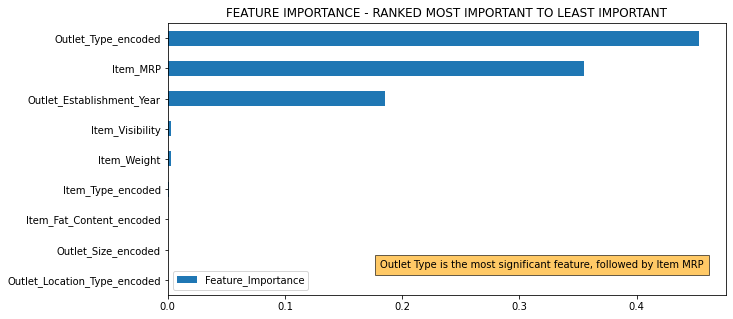


-----------------
Model: StackingRegressor(cv=5,
                  estimators=[('rf',
                               RandomForestRegressor(max_depth=6,
                                                     min_samples_leaf=50,
                                                     n_estimators=20)),
                              ('knn', KNeighborsRegressor(n_neighbors=10)),
                              ('cart',
                               DecisionTreeRegressor(max_depth=5,
                                                     max_leaf_nodes=20,
                                                     min_samples_split=3)),
                              ('svm', SVR())],
                  final_estimator=LinearRegression())
Training Score: 0.5422426577244083
Testing Score: 0.5223780758294359
Mean Squared Error: 933389.3199579995
Root Mean Squared Error: 966.1207584758747

   Actual Sales  Predicted Sales
0   1995.498739      1159.069390
1    339.828500       259.155998
2   3142.576000      

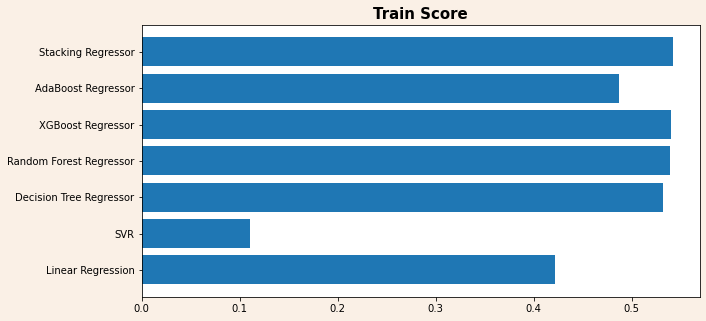

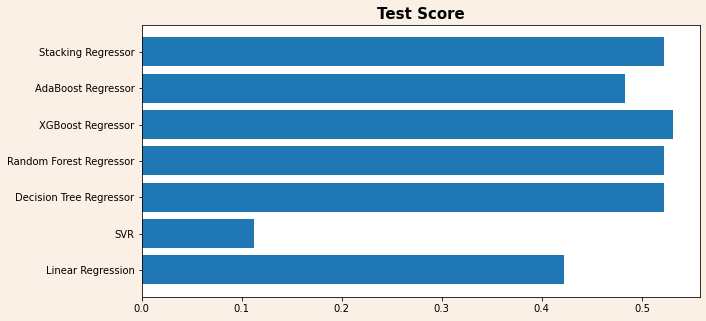

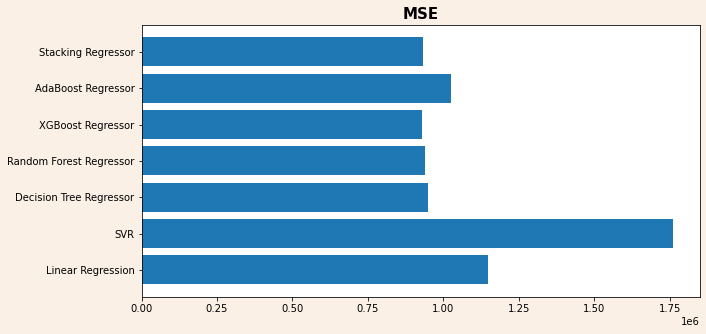

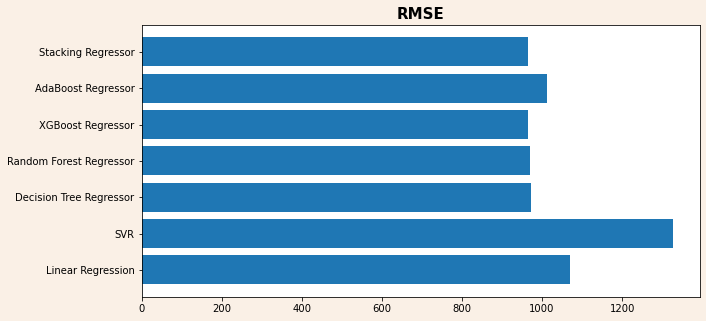

In [41]:
worker2.main()

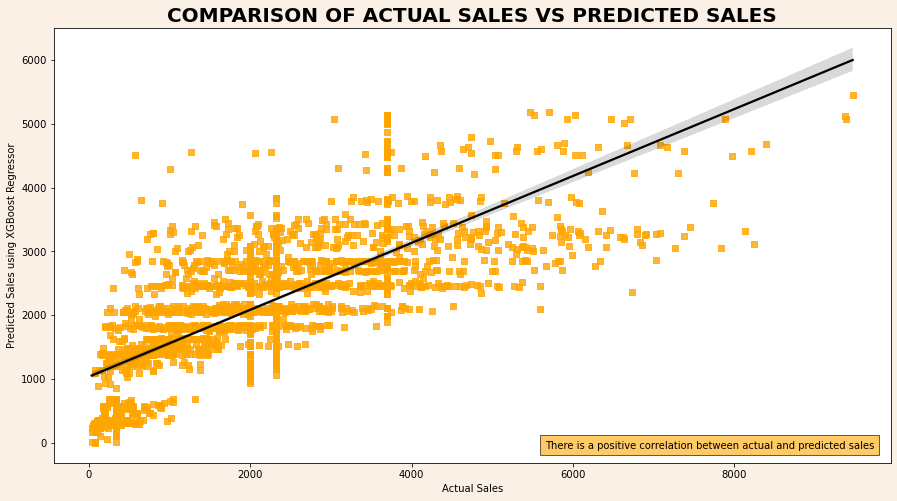

In [42]:
plt.figure(figsize=(15,8), facecolor='linen')
sb.regplot(y_test, xg_pred,scatter_kws={"color": "orange"}, line_kws={"color": "black"}, marker='s')
plt.title('COMPARISON OF ACTUAL SALES VS PREDICTED SALES', fontweight='bold', size=20)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales using XGBoost Regressor')
plt.figtext(0.58, 0.15, 'There is a positive correlation between actual and predicted sales', ha="left", fontsize=10, bbox={"facecolor":"orange", "alpha":0.6, "pad":5})
plt.show()

---